# Transfer Learning avec divers modèles de la famille ResNet50 et réglage des hyper-paramètres

Dans ce Notebook, nous souhaitons comparer les performances de différents modèles de la famille ResNet. Mais aussi effectuer le réglage des hyper-paramètres de notre meilleur modèle.

Imports des bibliothèques pour le projet

In [3]:
import time
import itertools
import os
import numpy as np
import pandas as pd
import sys
import json

"""
plot de graphes
"""
import matplotlib.pyplot as plt

"""
Création et gestion des modèles de classification d'images avec Keras
"""
from tensorflow import keras

#Accès aux images à classifier, qui sont réparties dans différents dossiers
from keras.preprocessing.image import ImageDataGenerator

#Différents types de couches pour les CNN
from keras.layers import Flatten, Dense, Activation

#Création de l'architecture des modèles avec Model
from keras.models import Model 

#Gestion des arrêtes anticipés
from keras.callbacks import EarlyStopping

#Utilisation de modèles enregistrés
from keras.models import load_model

"""
Importation des modèles pré-entraînés
"""

from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications.resnet import preprocess_input as preprocess_resnet

"""
Mesures de performance des modèles avec Sklearn
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1) Set up : fonctions utiles et initialisation

In [4]:
#infos du dataset
labels = os.listdir("./Garbage classification")
nClasses = len(labels) #6
inputFolder = "./Garbage_train_test_val"

#Hyper-paramètres
batch_size = 32
epochs_nb = 65

img_width, img_height = [224,224]

* **Gestion des différents modèles pré-entraînés**

In [5]:
def makeGeneratorsResNet(inputFolder, batch_size):

  input_shape = (img_width, img_height, 3)

  train_datagen = ImageDataGenerator( preprocessing_function = preprocess_resnet,
                                      width_shift_range=0.2, 
                                      height_shift_range=0.2, 
                                      horizontal_flip=True, 
                                      vertical_flip=True,
                                      rotation_range = 90,
                                      brightness_range = [0.8, 1.2],
                                      zoom_range = [0.8, 1],
                                      fill_mode='nearest')
  test_datagen = ImageDataGenerator(preprocessing_function = preprocess_resnet)

  train_generator = train_datagen.flow_from_directory(directory=r'./{}/train'.format(inputFolder),
                                                      target_size=(img_width, img_height),
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      seed=42)
  test_generator = test_datagen.flow_from_directory(directory=r'./{}/test'.format(inputFolder),
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
  validation_generator = test_datagen.flow_from_directory(directory=r'./{}/val'.format(inputFolder),
                                                          target_size=(img_width, img_height),
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False)

  return input_shape, train_generator, test_generator, validation_generator

def testGenerator(inputFolder):

  input_shape = (img_width, img_height, 3)

  test_datagen = ImageDataGenerator(preprocessing_function = preprocess_resnet)

  test_generator = test_datagen.flow_from_directory(directory=r'./{}/test'.format(inputFolder),
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

  return test_generator

def Architecture(model, nClasses):
  
  #Partie convolutive : on garde les paramètres des couches convolutives
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification : on ajoute une couche entièrement connectée ainsi que la dernière avec le bon nombre de classes
  #Seule cette partie sera entraînée par le modèle
  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

* **Etude des modèles**

In [6]:
def plot_accuracy_loss(history):
    """
    Retourne 2 graphes : un qui présente l'accuracy sur les sets de train et validation et le deuxième avec la loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    #Accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    ax1.plot(range(len(accuracy)), accuracy, label='train')
    ax1.plot(range(len(val_accuracy)), val_accuracy, label='validation')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    #Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(range(len(loss)), loss, label='train')
    ax2.plot(range(len(val_loss)), val_loss, label='validation')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Affiche la matrice de confusion du modèle sur les données de test
    """
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def study_model(model, classes, test_generator, executionTime, plot_cm=False):
    """
    Retourne des informations sur la performance du modèle
    """

    #Durée d'entraînement
    print(f"Durée d'entraînement : {round(executionTime, 2)} secondes")

    #Performances sur le set de test
    preds = model.predict(test_generator)  # preds are proba for each class
    preds_classes = [i.argmax() for i in preds]
    y_true = test_generator.classes
    acc_test = accuracy_score(y_true, preds_classes)
    prec_test = precision_score(y_true, preds_classes, average='weighted')
    rec_test = recall_score(y_true, preds_classes, average='weighted')
    f1_test = f1_score(y_true, preds_classes, average='weighted')
    results = pd.DataFrame([[acc_test, prec_test, rec_test, f1_test]], columns=['accuracy', 'precision', 'recall', 'f1-score'])
    print("\nPerformances sur le set de test : \n")
    print(results)

    #Matrice de confusion
    if (plot_cm):
      cm = confusion_matrix(y_true, preds_classes)
      plot_confusion_matrix(cm, classes)

# 2) Etude de ResNet101 et ResNet152

## ResNet101

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet101(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet101 = Architecture(model, nClasses)
model_resnet101.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
171458560/171446536 [==============================] - 2s 0us/step


In [ ]:
startTime=time.time()
history = model_resnet101.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet101.save('./Modeles/ResNet101.h5')

Epoch 1/65
56/56 [==============================] - 463s 8s/step - loss: 1.3307 - accuracy: 0.6178 - val_loss: 0.6745 - val_accuracy: 0.7666
Epoch 2/65
56/56 [==============================] - 46s 820ms/step - loss: 0.7350 - accuracy: 0.7593 - val_loss: 0.5571 - val_accuracy: 0.8090
Epoch 3/65
56/56 [==============================] - 46s 826ms/step - loss: 0.5785 - accuracy: 0.7978 - val_loss: 0.5443 - val_accuracy: 0.7958
Epoch 4/65
56/56 [==============================] - 46s 817ms/step - loss: 0.4828 - accuracy: 0.8409 - val_loss: 0.4442 - val_accuracy: 0.8276
Epoch 5/65
56/56 [==============================] - 45s 801ms/step - loss: 0.4298 - accuracy: 0.8545 - val_loss: 0.4627 - val_accuracy: 0.8382
Epoch 6/65
56/56 [==============================] - 45s 804ms/step - loss: 0.3882 - accuracy: 0.8652 - val_loss: 0.3544 - val_accuracy: 0.8886
Epoch 7/65
56/56 [==============================] - 46s 809ms/step - loss: 0.3746 - accuracy: 0.8788 - val_loss: 0.4233 - val_accuracy: 0.8594
E

In [ ]:
study_model(model_resnet101, labels, test_generator, executionTime)

Durée d'entraînement : 3461.37 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792   0.878015  0.869792  0.869377


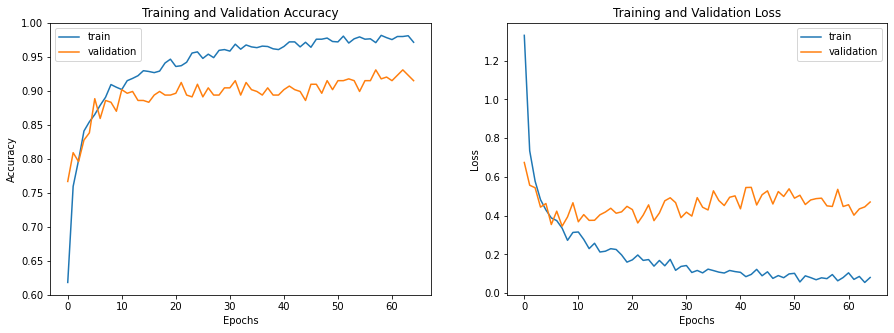

In [ ]:
plot_accuracy_loss(history)

## ResNet152

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet152(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet152 = Architecture(model, nClasses)
model_resnet152.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
234708992/234698864 [==============================] - 2s 0us/step


In [ ]:
startTime=time.time()
history = model_resnet152.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet152.save('./Modeles/ResNet152.h5')

Epoch 1/65
56/56 [==============================] - 67s 979ms/step - loss: 1.2976 - accuracy: 0.6200 - val_loss: 0.5723 - val_accuracy: 0.8037
Epoch 2/65
56/56 [==============================] - 51s 913ms/step - loss: 0.6863 - accuracy: 0.7718 - val_loss: 0.4926 - val_accuracy: 0.8355
Epoch 3/65
56/56 [==============================] - 50s 891ms/step - loss: 0.6051 - accuracy: 0.8154 - val_loss: 0.4986 - val_accuracy: 0.8435
Epoch 4/65
56/56 [==============================] - 52s 920ms/step - loss: 0.4689 - accuracy: 0.8386 - val_loss: 0.4516 - val_accuracy: 0.8647
Epoch 5/65
56/56 [==============================] - 51s 908ms/step - loss: 0.4118 - accuracy: 0.8562 - val_loss: 0.4431 - val_accuracy: 0.8727
Epoch 6/65
56/56 [==============================] - 50s 888ms/step - loss: 0.4019 - accuracy: 0.8698 - val_loss: 0.3823 - val_accuracy: 0.8780
Epoch 7/65
56/56 [==============================] - 50s 893ms/step - loss: 0.3394 - accuracy: 0.8913 - val_loss: 0.4784 - val_accuracy: 0.8700

In [ ]:
study_model(model_resnet152, labels, test_generator, executionTime)

Durée d'entraînement : 3312.57 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792   0.879276  0.869792  0.868402


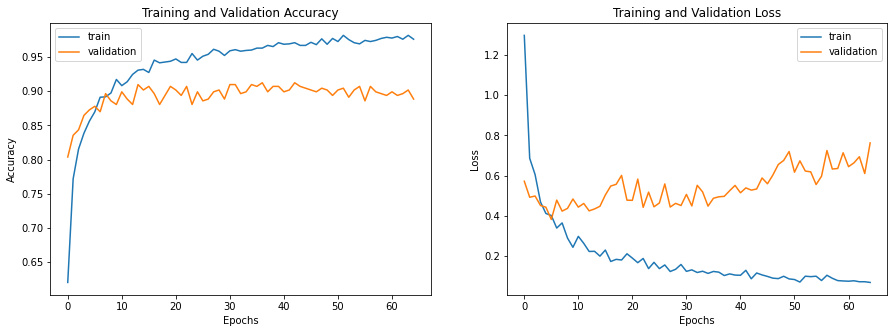

In [ ]:
plot_accuracy_loss(history)

## Comparaison des modèles avec ResNet

In [ ]:
def load_model_fill_df(modelName, df, inputFolder):

  model = load_model(f'./Modeles/{modelName}.h5')
  test_generator = testGenerator(inputFolder)
  preds         = model.predict(test_generator)
  preds_classes = [i.argmax() for i in preds]
  y_true        = test_generator.classes

  acc_test = accuracy_score(y_true, preds_classes)
  prec_test = precision_score(y_true, preds_classes, average='weighted')
  rec_test = recall_score(y_true, preds_classes, average='weighted')
  f1_test = f1_score(y_true, preds_classes, average='weighted')
  params_number = model.count_params() 
  params_number_millions = round(params_number/1000000,1) #conversion en millions

  results = { 'modelName': modelName, 
              'accuracy': acc_test, 
              'precision': prec_test,
              'recall' : rec_test,
              'f1-score' : f1_test,
              'parameters_number (M)' : params_number_millions}

  df = df.append(results, ignore_index = True)

  return df 

In [ ]:
models_list = ["ResNet50", "ResNet101", "ResNet152"]

results_df = pd.DataFrame(columns=['modelName', 'accuracy', 'precision', 'recall', 'f1-score', 'parameters_number (M)'])

for model in models_list:
  results_df = load_model_fill_df(model, results_df, inputFolder)

Found 384 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 384 images belonging to 6 classes.


On trie notre DataFrame dans l'ordre décroissant des valeurs d'accuracy.

In [ ]:
results_df = results_df.sort_values(["accuracy"], ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,modelName,accuracy,precision,recall,f1-score,parameters_number (M)
0,ResNet50,0.885417,0.887026,0.885417,0.884463,49.3
1,ResNet101,0.869792,0.878015,0.869792,0.869377,68.4
2,ResNet152,0.869792,0.879276,0.869792,0.868402,84.1


In [ ]:
#Ajout du temps d'exécution
execution_time_dict = { 'ResNet50' : 2592,
                        'ResNet101' : 3461.37, 
                        'ResNet152' : 3312.57}

#Conversion en minutes
execution_time_dict = dict(map(lambda x: (x[0], round(x[1]/60, 2)), execution_time_dict.items()))

results_df['execution_time (min)'] = results_df['modelName'].map(execution_time_dict)

In [ ]:
def colour_numbers(column):
    green    = 'background-color: green;'
    red = 'background-color: red;'     
    default = ''

    maximum_in_column = column.max()
    minimum_in_column = column.min()

    return [red if v == maximum_in_column else green if v == minimum_in_column else default for v in column]  


results_df.style.highlight_max(subset=['accuracy', 'precision', 'recall', 'f1-score'], axis=0).apply(colour_numbers, subset=['parameters_number (M)', 'execution_time (min)'], axis=0)

,modelName,accuracy,precision,recall,f1-score,parameters_number (M),execution_time (min)
0,ResNet50,0.885417,0.887026,0.885417,0.884463,49.300000,43.200000
1,ResNet101,0.869792,0.878015,0.869792,0.869377,68.400000,57.690000
2,ResNet152,0.869792,0.879276,0.869792,0.868402,84.100000,55.210000


Conclusion : ResNet50 est légèrement meilleur en termes de performances et bien meilleur en temps de calcul avec beaucoup moins de paramètres.

# 3) Hyper-paramètres de ResNet50

a) Learning rate

b) Optimiseur

c) Batch size

d) freeze random layers

## a) Optimiseur

Dans un premier temps, nous allons essayer de tester divers optimiseurs à savoir Adam, AdaGrad et Adadelta.

* Adam

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_adam = Architecture(model, nClasses)
model_resnet50_adam.compile(loss='categorical_crossentropy', 
                            optimizer=keras.optimizers.Adam(learning_rate=2e-5), 
                            metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_resnet50_adam.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_adam.save('./Modeles/ResNet50_Adam.h5')

Epoch 1/65
56/56 [==============================] - 845s 15s/step - loss: 1.2707 - accuracy: 0.6070 - val_loss: 0.6649 - val_accuracy: 0.7984
Epoch 2/65
56/56 [==============================] - 41s 725ms/step - loss: 0.6484 - accuracy: 0.7707 - val_loss: 0.5759 - val_accuracy: 0.8117
Epoch 3/65
56/56 [==============================] - 41s 731ms/step - loss: 0.4864 - accuracy: 0.8307 - val_loss: 0.5709 - val_accuracy: 0.8117
Epoch 4/65
56/56 [==============================] - 41s 732ms/step - loss: 0.4810 - accuracy: 0.8347 - val_loss: 0.4880 - val_accuracy: 0.8382
Epoch 5/65
56/56 [==============================] - 41s 730ms/step - loss: 0.4113 - accuracy: 0.8567 - val_loss: 0.4557 - val_accuracy: 0.8408
Epoch 6/65
56/56 [==============================] - 41s 729ms/step - loss: 0.4134 - accuracy: 0.8579 - val_loss: 0.5123 - val_accuracy: 0.8276
Epoch 7/65
56/56 [==============================] - 41s 724ms/step - loss: 0.3415 - accuracy: 0.8879 - val_loss: 0.4591 - val_accuracy: 0.8435


In [ ]:
study_model(model_resnet50_adam, labels, test_generator, executionTime)

Durée d'entraînement : 3621.92 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.856771   0.857898  0.856771  0.855651


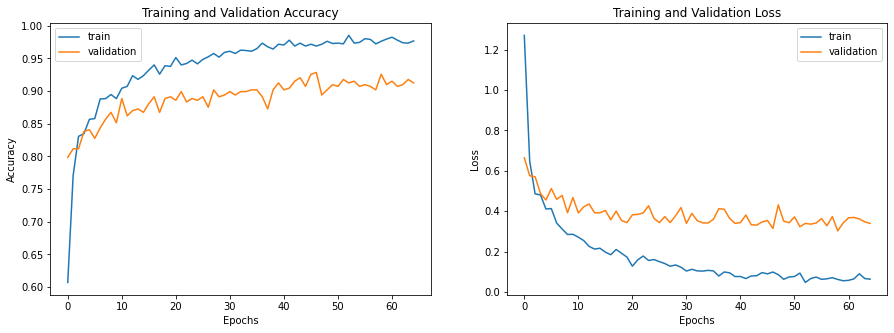

In [ ]:
plot_accuracy_loss(history)

* Adagrad

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_adagrad = Architecture(model, nClasses)
model_resnet50_adagrad.compile(loss='categorical_crossentropy', 
                            optimizer=keras.optimizers.Adagrad(learning_rate=2e-5), 
                            metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_adagrad.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_adagrad.save('./Modeles/ResNet50_Adagrad.h5')

Epoch 1/65
56/56 [==============================] - 46s 749ms/step - loss: 2.3221 - accuracy: 0.2922 - val_loss: 1.6807 - val_accuracy: 0.4615
Epoch 2/65
56/56 [==============================] - 40s 720ms/step - loss: 1.5710 - accuracy: 0.4615 - val_loss: 1.3602 - val_accuracy: 0.5570
Epoch 3/65
56/56 [==============================] - 42s 742ms/step - loss: 1.3681 - accuracy: 0.5283 - val_loss: 1.1947 - val_accuracy: 0.6180
Epoch 4/65
56/56 [==============================] - 42s 750ms/step - loss: 1.1895 - accuracy: 0.5866 - val_loss: 1.0819 - val_accuracy: 0.6472
Epoch 5/65
56/56 [==============================] - 42s 739ms/step - loss: 1.0867 - accuracy: 0.6121 - val_loss: 1.0067 - val_accuracy: 0.6737
Epoch 6/65
56/56 [==============================] - 42s 748ms/step - loss: 1.0233 - accuracy: 0.6353 - val_loss: 0.9473 - val_accuracy: 0.6817
Epoch 7/65
56/56 [==============================] - 41s 725ms/step - loss: 0.9498 - accuracy: 0.6580 - val_loss: 0.9055 - val_accuracy: 0.6950

In [ ]:
study_model(model_resnet50_adagrad, labels, test_generator, executionTime)

Durée d'entraînement : 2690.13 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.799479   0.799044  0.799479  0.798486


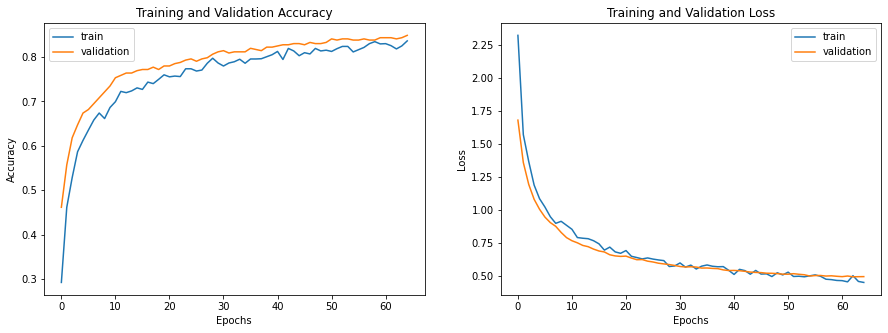

In [ ]:
plot_accuracy_loss(history)

* Adadelta

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_adadelta = Architecture(model, nClasses)
model_resnet50_adadelta.compile(loss='categorical_crossentropy', 
                            optimizer=keras.optimizers.Adadelta(learning_rate=2e-5), 
                            metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_resnet50_adadelta.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_adadelta.save('./Modeles/ResNet50_Adadelta.h5')

Epoch 1/65
56/56 [==============================] - 440s 8s/step - loss: 3.8957 - accuracy: 0.1263 - val_loss: 4.0196 - val_accuracy: 0.1194
Epoch 2/65
56/56 [==============================] - 44s 785ms/step - loss: 3.6482 - accuracy: 0.1529 - val_loss: 3.9072 - val_accuracy: 0.1194
Epoch 3/65
56/56 [==============================] - 44s 782ms/step - loss: 3.4694 - accuracy: 0.1580 - val_loss: 3.8091 - val_accuracy: 0.1141
Epoch 4/65
56/56 [==============================] - 45s 795ms/step - loss: 3.3969 - accuracy: 0.1586 - val_loss: 3.7217 - val_accuracy: 0.1194
Epoch 5/65
56/56 [==============================] - 44s 778ms/step - loss: 3.2744 - accuracy: 0.1574 - val_loss: 3.6413 - val_accuracy: 0.1300
Epoch 6/65
56/56 [==============================] - 44s 778ms/step - loss: 3.2517 - accuracy: 0.1704 - val_loss: 3.5682 - val_accuracy: 0.1353
Epoch 7/65
56/56 [==============================] - 44s 780ms/step - loss: 3.2174 - accuracy: 0.1659 - val_loss: 3.5001 - val_accuracy: 0.1406
E

In [ ]:
study_model(model_resnet50_adadelta, labels, test_generator, executionTime)

Durée d'entraînement : 3335.25 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.315104   0.317894  0.315104  0.315374


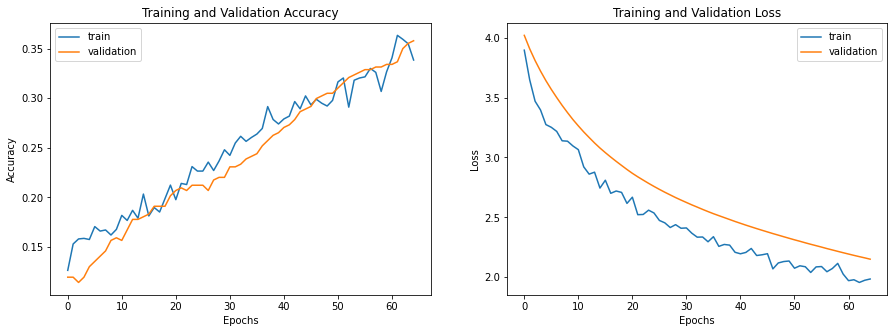

In [ ]:
plot_accuracy_loss(history)

## b) Learning rate

* 1e-1

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_01 = Architecture(model, nClasses)
model_resnet50_01.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-1), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_01.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_01.save('./Modeles/ResNet50_01.h5')

Epoch 1/65
56/56 [==============================] - 49s 788ms/step - loss: 4899.2695 - accuracy: 0.2967 - val_loss: 2.0670 - val_accuracy: 0.2997
Epoch 2/65
56/56 [==============================] - 44s 790ms/step - loss: 8.6763 - accuracy: 0.3103 - val_loss: 2.9299 - val_accuracy: 0.3316
Epoch 3/65
56/56 [==============================] - 43s 758ms/step - loss: 7.9118 - accuracy: 0.2831 - val_loss: 1.8755 - val_accuracy: 0.2732
Epoch 4/65
56/56 [==============================] - 44s 783ms/step - loss: 2.9449 - accuracy: 0.2792 - val_loss: 4.9190 - val_accuracy: 0.3501
Epoch 5/65
56/56 [==============================] - 42s 751ms/step - loss: 2.6084 - accuracy: 0.2763 - val_loss: 1.6184 - val_accuracy: 0.2732
Epoch 6/65
56/56 [==============================] - 42s 745ms/step - loss: 2.0060 - accuracy: 0.2412 - val_loss: 1.6076 - val_accuracy: 0.2599
Epoch 7/65
56/56 [==============================] - 43s 760ms/step - loss: 2.7377 - accuracy: 0.2633 - val_loss: 1.6928 - val_accuracy: 0.2

In [ ]:
study_model(model_resnet50_01, labels, test_generator, executionTime)

Durée d'entraînement : 2756.33 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.276042   0.216174  0.276042   0.15813


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


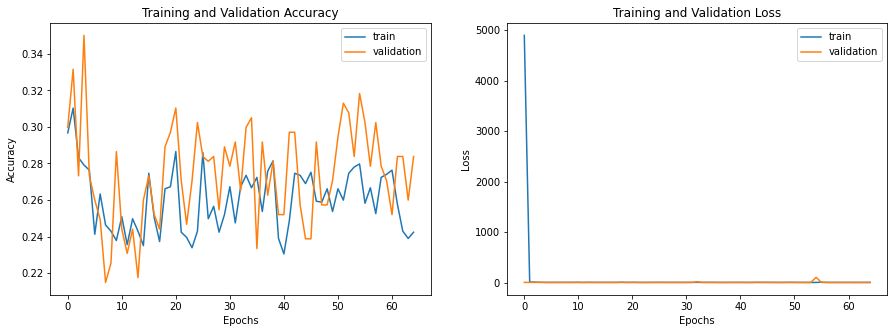

In [ ]:
plot_accuracy_loss(history)

* 1e-2

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_001 = Architecture(model, nClasses)
model_resnet50_001.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-2), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
startTime=time.time()
history = model_resnet50_001.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_001.save('./Modeles/ResNet50_001.h5')

Epoch 1/65
56/56 [==============================] - 447s 8s/step - loss: 241.6697 - accuracy: 0.5062 - val_loss: 1.8177 - val_accuracy: 0.5889
Epoch 2/65
56/56 [==============================] - 42s 742ms/step - loss: 2.5784 - accuracy: 0.4785 - val_loss: 2.5406 - val_accuracy: 0.4615
Epoch 3/65
56/56 [==============================] - 43s 762ms/step - loss: 1.8872 - accuracy: 0.3998 - val_loss: 1.5017 - val_accuracy: 0.3475
Epoch 4/65
56/56 [==============================] - 41s 737ms/step - loss: 2.0889 - accuracy: 0.3890 - val_loss: 2.2464 - val_accuracy: 0.3740
Epoch 5/65
56/56 [==============================] - 40s 721ms/step - loss: 1.8096 - accuracy: 0.4179 - val_loss: 1.5223 - val_accuracy: 0.3687
Epoch 6/65
56/56 [==============================] - 41s 721ms/step - loss: 2.5256 - accuracy: 0.4139 - val_loss: 3.5644 - val_accuracy: 0.5040
Epoch 7/65
56/56 [==============================] - 41s 735ms/step - loss: 1.7145 - accuracy: 0.4343 - val_loss: 1.8871 - val_accuracy: 0.4960

In [ ]:
study_model(model_resnet50_001, labels, test_generator, executionTime)

Durée d'entraînement : 3105.7 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.596354   0.825364  0.596354  0.607714


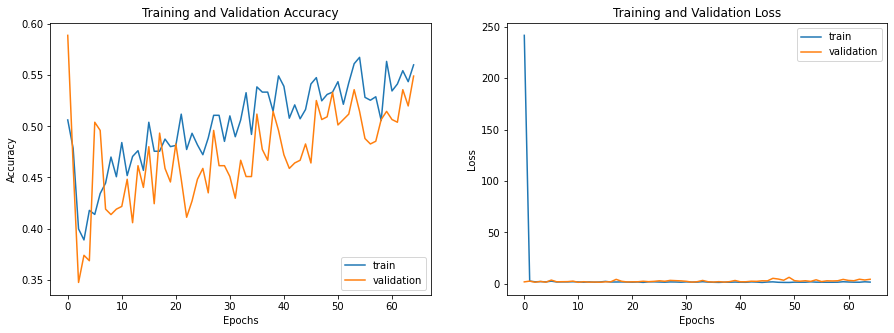

In [ ]:
plot_accuracy_loss(history)

* 1e-3

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_0001 = Architecture(model, nClasses)
model_resnet50_0001.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_0001.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_0001.save('./Modeles/ResNet50_0001.h5')

Epoch 1/65
56/56 [==============================] - 48s 777ms/step - loss: 16.2450 - accuracy: 0.5997 - val_loss: 1.3953 - val_accuracy: 0.7772
Epoch 2/65
56/56 [==============================] - 42s 749ms/step - loss: 1.3564 - accuracy: 0.7293 - val_loss: 1.1979 - val_accuracy: 0.7401
Epoch 3/65
56/56 [==============================] - 42s 745ms/step - loss: 1.0364 - accuracy: 0.7395 - val_loss: 0.7348 - val_accuracy: 0.8302
Epoch 4/65
56/56 [==============================] - 42s 746ms/step - loss: 0.8628 - accuracy: 0.7752 - val_loss: 1.0815 - val_accuracy: 0.7215
Epoch 5/65
56/56 [==============================] - 42s 742ms/step - loss: 0.8758 - accuracy: 0.7933 - val_loss: 0.4828 - val_accuracy: 0.8196
Epoch 6/65
56/56 [==============================] - 42s 744ms/step - loss: 0.7179 - accuracy: 0.8029 - val_loss: 0.8185 - val_accuracy: 0.7560
Epoch 7/65
56/56 [==============================] - 42s 743ms/step - loss: 0.5638 - accuracy: 0.8392 - val_loss: 0.5394 - val_accuracy: 0.824

In [ ]:
study_model(model_resnet50_0001, labels, test_generator, executionTime)

Durée d'entraînement : 2756.33 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792   0.873058  0.869792  0.869558


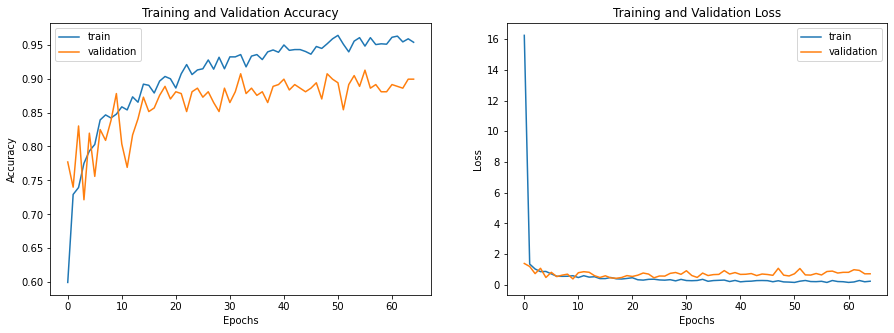

In [ ]:
plot_accuracy_loss(history)

* 1e-4

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_00001 = Architecture(model, nClasses)
model_resnet50_00001.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_00001.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_00001.save('./Modeles/ResNet50_00001.h5')

Epoch 1/65
56/56 [==============================] - 47s 766ms/step - loss: 2.2344 - accuracy: 0.6223 - val_loss: 0.6663 - val_accuracy: 0.7878
Epoch 2/65
56/56 [==============================] - 45s 798ms/step - loss: 0.7220 - accuracy: 0.7690 - val_loss: 0.6960 - val_accuracy: 0.8037
Epoch 3/65
56/56 [==============================] - 43s 763ms/step - loss: 0.6297 - accuracy: 0.8075 - val_loss: 0.8036 - val_accuracy: 0.7692
Epoch 4/65
56/56 [==============================] - 41s 739ms/step - loss: 0.6036 - accuracy: 0.8222 - val_loss: 0.5584 - val_accuracy: 0.8329
Epoch 5/65
56/56 [==============================] - 42s 744ms/step - loss: 0.4776 - accuracy: 0.8454 - val_loss: 0.5147 - val_accuracy: 0.8674
Epoch 6/65
56/56 [==============================] - 43s 759ms/step - loss: 0.4929 - accuracy: 0.8613 - val_loss: 0.5688 - val_accuracy: 0.8408
Epoch 7/65
56/56 [==============================] - 41s 725ms/step - loss: 0.4585 - accuracy: 0.8737 - val_loss: 0.7174 - val_accuracy: 0.7639

In [ ]:
study_model(model_resnet50_00001, labels, test_generator, executionTime)

Durée d'entraînement : 2667.3 secondes

Performances sur le set de test : 

   accuracy  precision  recall  f1-score
0     0.875     0.8755   0.875  0.874144


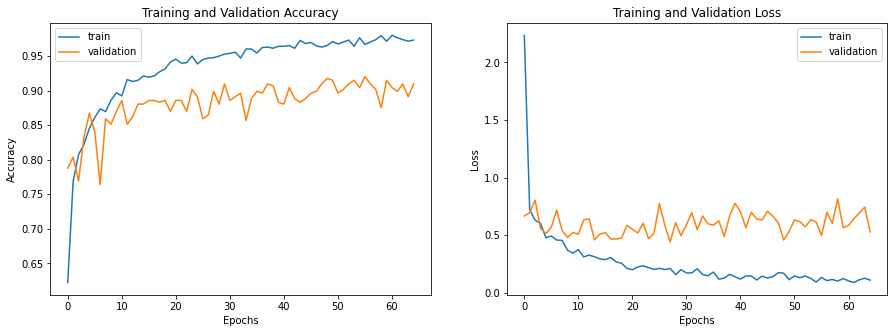

In [ ]:
plot_accuracy_loss(history)

* 1e-5

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_000001 = Architecture(model, nClasses)
model_resnet50_000001.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_000001.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_000001.save('./Modeles/ResNet50_000001.h5')

Epoch 1/65
56/56 [==============================] - 48s 790ms/step - loss: 1.3472 - accuracy: 0.5646 - val_loss: 0.7438 - val_accuracy: 0.7401
Epoch 2/65
56/56 [==============================] - 43s 763ms/step - loss: 0.7756 - accuracy: 0.7356 - val_loss: 0.6340 - val_accuracy: 0.7984
Epoch 3/65
56/56 [==============================] - 42s 747ms/step - loss: 0.6460 - accuracy: 0.7860 - val_loss: 0.4798 - val_accuracy: 0.8276
Epoch 4/65
56/56 [==============================] - 42s 743ms/step - loss: 0.5385 - accuracy: 0.8103 - val_loss: 0.4756 - val_accuracy: 0.8355
Epoch 5/65
56/56 [==============================] - 42s 754ms/step - loss: 0.4733 - accuracy: 0.8318 - val_loss: 0.4379 - val_accuracy: 0.8515
Epoch 6/65
56/56 [==============================] - 42s 741ms/step - loss: 0.4246 - accuracy: 0.8494 - val_loss: 0.4204 - val_accuracy: 0.8647
Epoch 7/65
56/56 [==============================] - 42s 744ms/step - loss: 0.4208 - accuracy: 0.8482 - val_loss: 0.4164 - val_accuracy: 0.8594

In [ ]:
study_model(model_resnet50_000001, labels, test_generator, executionTime)

Durée d'entraînement : 2823.56 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.859375   0.861288  0.859375  0.858116


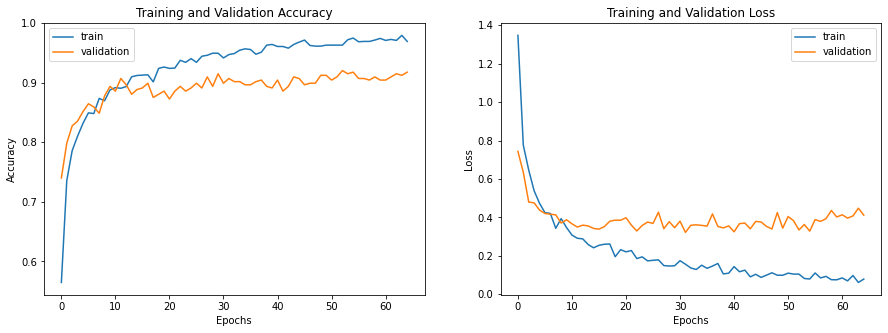

In [ ]:
plot_accuracy_loss(history)

* 1e-6

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_0000001 = Architecture(model, nClasses)
model_resnet50_0000001.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-6), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_0000001.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_0000001.save('./Modeles/ResNet50_0000001.h5')

Epoch 1/65
56/56 [==============================] - 47s 771ms/step - loss: 2.4753 - accuracy: 0.2650 - val_loss: 1.9789 - val_accuracy: 0.3634
Epoch 2/65
56/56 [==============================] - 42s 749ms/step - loss: 1.8283 - accuracy: 0.3947 - val_loss: 1.5787 - val_accuracy: 0.4775
Epoch 3/65
56/56 [==============================] - 42s 753ms/step - loss: 1.4766 - accuracy: 0.5045 - val_loss: 1.3483 - val_accuracy: 0.5411
Epoch 4/65
56/56 [==============================] - 42s 749ms/step - loss: 1.2715 - accuracy: 0.5600 - val_loss: 1.1614 - val_accuracy: 0.6127
Epoch 5/65
56/56 [==============================] - 42s 747ms/step - loss: 1.1639 - accuracy: 0.6031 - val_loss: 1.0426 - val_accuracy: 0.6366
Epoch 6/65
56/56 [==============================] - 42s 756ms/step - loss: 1.0824 - accuracy: 0.6331 - val_loss: 0.9518 - val_accuracy: 0.6737
Epoch 7/65
56/56 [==============================] - 42s 755ms/step - loss: 0.9570 - accuracy: 0.6597 - val_loss: 0.8787 - val_accuracy: 0.6950

In [ ]:
study_model(model_resnet50_0000001, labels, test_generator, executionTime)

Durée d'entraînement : 2728.5 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.828125   0.831973  0.828125  0.827934


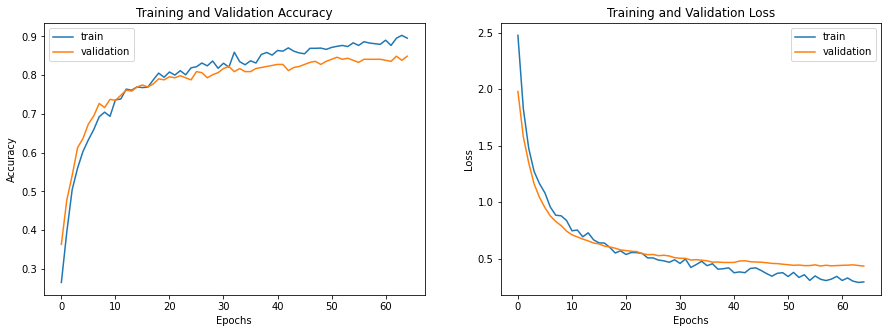

In [ ]:
plot_accuracy_loss(history)

## c) Batch size

* batch size = 16

In [ ]:
batch_size = 16

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_bs16 = Architecture(model, nClasses)
model_resnet50_bs16.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_bs16.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_bs16.save('./Modeles/ResNet50_bs16.h5')

Epoch 1/65
111/111 [==============================] - 49s 394ms/step - loss: 1.1830 - accuracy: 0.6591 - val_loss: 0.5258 - val_accuracy: 0.8037
Epoch 2/65
111/111 [==============================] - 42s 381ms/step - loss: 0.6854 - accuracy: 0.7741 - val_loss: 0.4838 - val_accuracy: 0.8355
Epoch 3/65
111/111 [==============================] - 42s 376ms/step - loss: 0.6189 - accuracy: 0.8069 - val_loss: 0.3898 - val_accuracy: 0.8859
Epoch 4/65
111/111 [==============================] - 43s 387ms/step - loss: 0.4851 - accuracy: 0.8437 - val_loss: 0.4996 - val_accuracy: 0.8515
Epoch 5/65
111/111 [==============================] - 41s 372ms/step - loss: 0.4699 - accuracy: 0.8579 - val_loss: 0.4727 - val_accuracy: 0.8674
Epoch 6/65
111/111 [==============================] - 41s 372ms/step - loss: 0.4401 - accuracy: 0.8584 - val_loss: 0.6397 - val_accuracy: 0.8249
Epoch 7/65
111/111 [==============================] - 41s 371ms/step - loss: 0.3827 - accuracy: 0.8834 - val_loss: 0.4153 - val_ac

In [ ]:
study_model(model_resnet50_bs16, labels, test_generator, executionTime)

Durée d'entraînement : 2703.75 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.864583   0.866807  0.864583  0.863677


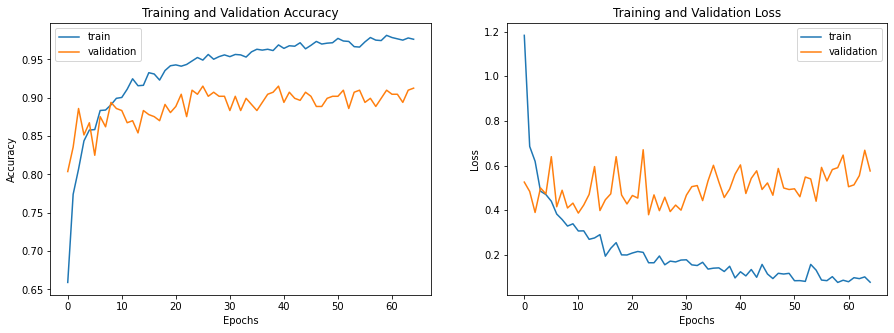

In [ ]:
plot_accuracy_loss(history)

* batch size = 64

In [ ]:
batch_size = 64

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_bs64 = Architecture(model, nClasses)
model_resnet50_bs64.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_bs64.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_bs64.save('./Modeles/ResNet50_bs64.h5')

Epoch 1/65
28/28 [==============================] - 742s 26s/step - loss: 1.7872 - accuracy: 0.5770 - val_loss: 0.7588 - val_accuracy: 0.7401
Epoch 2/65
28/28 [==============================] - 40s 1s/step - loss: 0.7487 - accuracy: 0.7418 - val_loss: 0.6068 - val_accuracy: 0.7639
Epoch 3/65
28/28 [==============================] - 40s 1s/step - loss: 0.5950 - accuracy: 0.7871 - val_loss: 0.5838 - val_accuracy: 0.7984
Epoch 4/65
28/28 [==============================] - 40s 1s/step - loss: 0.5514 - accuracy: 0.8092 - val_loss: 0.4497 - val_accuracy: 0.8462
Epoch 5/65
28/28 [==============================] - 40s 1s/step - loss: 0.4686 - accuracy: 0.8381 - val_loss: 0.4395 - val_accuracy: 0.8462
Epoch 6/65
28/28 [==============================] - 40s 1s/step - loss: 0.4232 - accuracy: 0.8482 - val_loss: 0.4419 - val_accuracy: 0.8435
Epoch 7/65
28/28 [==============================] - 40s 1s/step - loss: 0.3983 - accuracy: 0.8522 - val_loss: 0.4499 - val_accuracy: 0.8435
Epoch 8/65
28/28 [

In [ ]:
study_model(model_resnet50_bs64, labels, test_generator, executionTime)

Durée d'entraînement : 3293.18 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.880208   0.880853  0.880208  0.879017


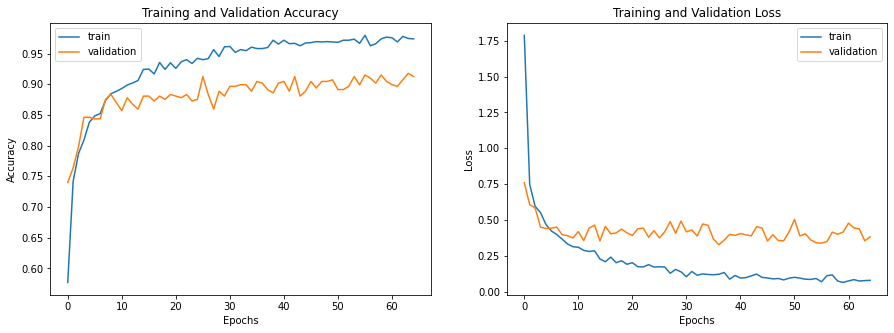

In [ ]:
plot_accuracy_loss(history)

* batch size = 100

In [ ]:
batch_size = 100

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_bs100 = Architecture(model, nClasses)
model_resnet50_bs100.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_bs100.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_bs100.save('./Modeles/ResNet50_bs100.h5')

Epoch 1/65
18/18 [==============================] - 50s 2s/step - loss: 1.9852 - accuracy: 0.5153 - val_loss: 0.9124 - val_accuracy: 0.6764
Epoch 2/65
18/18 [==============================] - 42s 2s/step - loss: 0.7937 - accuracy: 0.7191 - val_loss: 0.5718 - val_accuracy: 0.8037
Epoch 3/65
18/18 [==============================] - 41s 2s/step - loss: 0.6468 - accuracy: 0.7729 - val_loss: 0.5641 - val_accuracy: 0.8170
Epoch 4/65
18/18 [==============================] - 42s 2s/step - loss: 0.5635 - accuracy: 0.8018 - val_loss: 0.4673 - val_accuracy: 0.8355
Epoch 5/65
18/18 [==============================] - 40s 2s/step - loss: 0.5111 - accuracy: 0.8160 - val_loss: 0.4375 - val_accuracy: 0.8435
Epoch 6/65
18/18 [==============================] - 40s 2s/step - loss: 0.4585 - accuracy: 0.8398 - val_loss: 0.4033 - val_accuracy: 0.8647
Epoch 7/65
18/18 [==============================] - 40s 2s/step - loss: 0.4161 - accuracy: 0.8562 - val_loss: 0.3956 - val_accuracy: 0.8594
Epoch 8/65
18/18 [==

In [ ]:
study_model(model_resnet50_bs100, labels, test_generator, executionTime)

Durée d'entraînement : 2589.33 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792   0.873897  0.869792  0.868316


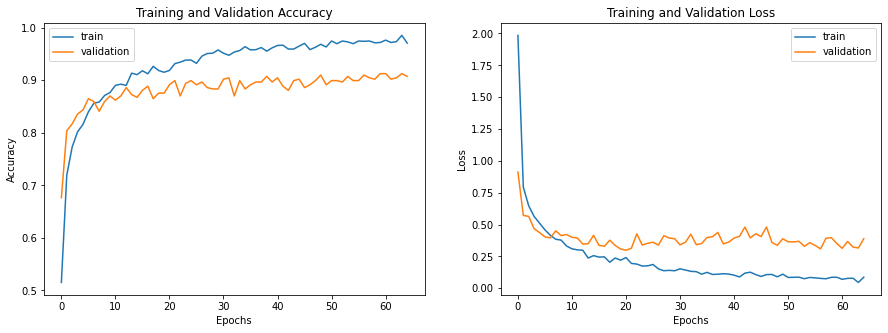

In [ ]:
plot_accuracy_loss(history)

# 4) Fine Tuning

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
len(model.layers)

175

Le modèle ResNet50 comporte 175 couches dans la partie convolutives. Depuis le début de notre expérience, ces couches étaient gelées durant l'entraînement donc le poids des neurones étaient conservés par rapport à l'entraînement sur ImageNet. Nous allons voir si les performances s'améliorent lorsque nous entraînons quleques unes de ces couches (celles qui précèdent l'entrée dans le MLP).

In [ ]:
def Architecture_finetuning(model, nClasses, nLayers_totrain):

  len_model_to_freeze = len(model.layers) - nLayers_totrain
  #Partie convolutive : on garde les paramètres des premières couches convolutives mais on entraîne les nLayers_totrain dernières
  for layer in model.layers[:len_model_to_freeze]:
    layer.trainable = False
    
  lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification : on ajoute une couche entièrement connectée ainsi que la dernière avec le bon nombre de classes
  #Seule cette partie sera entraînée par le modèle
  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

* 15 couches

In [ ]:
nLayers_totrain = 15
model_resnet50_ft15 = Architecture_finetuning(model, nClasses, nLayers_totrain)
model_resnet50_ft15.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

In [ ]:
startTime=time.time()
history = model_resnet50_ft15.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_ft15.save('./Modeles/ResNet50_ft15.h5')

Epoch 1/65
56/56 [==============================] - 1008s 18s/step - loss: 1.2977 - accuracy: 0.6195 - val_loss: 0.6526 - val_accuracy: 0.7905
Epoch 2/65
56/56 [==============================] - 42s 741ms/step - loss: 0.7558 - accuracy: 0.7480 - val_loss: 0.5298 - val_accuracy: 0.8143
Epoch 3/65
56/56 [==============================] - 42s 742ms/step - loss: 0.5702 - accuracy: 0.8120 - val_loss: 0.4893 - val_accuracy: 0.8435
Epoch 4/65
56/56 [==============================] - 42s 745ms/step - loss: 0.4372 - accuracy: 0.8556 - val_loss: 0.4291 - val_accuracy: 0.8541
Epoch 5/65
56/56 [==============================] - 42s 745ms/step - loss: 0.4394 - accuracy: 0.8545 - val_loss: 0.4426 - val_accuracy: 0.8488
Epoch 6/65
56/56 [==============================] - 42s 741ms/step - loss: 0.3873 - accuracy: 0.8709 - val_loss: 0.5192 - val_accuracy: 0.8515
Epoch 7/65
56/56 [==============================] - 42s 745ms/step - loss: 0.3366 - accuracy: 0.8873 - val_loss: 0.4711 - val_accuracy: 0.8594

In [ ]:
study_model(model_resnet50_ft15, labels, test_generator, executionTime)

Durée d'entraînement : 3801.41 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.888021   0.891558  0.888021  0.887845


In [ ]:
import json
history_dict = history.history
json.dump(history_dict, open("history_ft15", 'w'))

* 30 couches

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
nLayers_totrain = 30
model_resnet50_ft30 = Architecture_finetuning(model, nClasses, nLayers_totrain)
model_resnet50_ft30.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_ft30.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_ft30.save('./Modeles/ResNet50_ft30.h5')
history_dict = history.history
json.dump(history_dict, open("history_ft30", 'w'))


Epoch 1/65
56/56 [==============================] - 50s 800ms/step - loss: 1.3485 - accuracy: 0.5951 - val_loss: 0.6937 - val_accuracy: 0.7533
Epoch 2/65
56/56 [==============================] - 45s 804ms/step - loss: 0.7287 - accuracy: 0.7588 - val_loss: 0.5095 - val_accuracy: 0.8117
Epoch 3/65
56/56 [==============================] - 43s 769ms/step - loss: 0.5867 - accuracy: 0.7990 - val_loss: 0.4892 - val_accuracy: 0.8408
Epoch 4/65
56/56 [==============================] - 43s 758ms/step - loss: 0.4846 - accuracy: 0.8307 - val_loss: 0.4398 - val_accuracy: 0.8647
Epoch 5/65
56/56 [==============================] - 43s 764ms/step - loss: 0.4337 - accuracy: 0.8539 - val_loss: 0.4321 - val_accuracy: 0.8674
Epoch 6/65
56/56 [==============================] - 43s 761ms/step - loss: 0.4071 - accuracy: 0.8601 - val_loss: 0.4279 - val_accuracy: 0.8939
Epoch 7/65
56/56 [==============================] - 42s 751ms/step - loss: 0.3406 - accuracy: 0.8822 - val_loss: 0.3826 - val_accuracy: 0.9019

In [ ]:
study_model(model_resnet50_ft30, labels, test_generator, executionTime)

Durée d'entraînement : 2857.97 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.890625   0.892093  0.890625  0.890464


* 50 couches

In [ ]:
import json

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
nLayers_totrain = 50
model_resnet50_ft50 = Architecture_finetuning(model, nClasses, nLayers_totrain)
model_resnet50_ft50.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_ft50.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_ft50.save('./Modeles/ResNet50_ft50.h5')
history_dict = history.history
json.dump(history_dict, open("history_ft50", 'w'))

Epoch 1/65
56/56 [==============================] - 54s 837ms/step - loss: 1.3471 - accuracy: 0.5849 - val_loss: 0.8705 - val_accuracy: 0.7003
Epoch 2/65
56/56 [==============================] - 45s 804ms/step - loss: 0.7534 - accuracy: 0.7390 - val_loss: 0.5342 - val_accuracy: 0.8435
Epoch 3/65
56/56 [==============================] - 45s 804ms/step - loss: 0.5882 - accuracy: 0.8001 - val_loss: 0.5250 - val_accuracy: 0.8355
Epoch 4/65
56/56 [==============================] - 44s 786ms/step - loss: 0.5173 - accuracy: 0.8296 - val_loss: 0.5392 - val_accuracy: 0.8408
Epoch 5/65
56/56 [==============================] - 45s 800ms/step - loss: 0.4429 - accuracy: 0.8550 - val_loss: 0.4591 - val_accuracy: 0.8621
Epoch 6/65
56/56 [==============================] - 46s 809ms/step - loss: 0.3830 - accuracy: 0.8732 - val_loss: 0.3621 - val_accuracy: 0.8992
Epoch 7/65
56/56 [==============================] - 47s 827ms/step - loss: 0.3338 - accuracy: 0.8941 - val_loss: 0.4181 - val_accuracy: 0.9019

In [ ]:
study_model(model_resnet50_ft50, labels, test_generator, executionTime)

Durée d'entraînement : 2982.83 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.890625   0.892194  0.890625  0.890606


* Tout le réseau

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
nLayers_totrain = len(model.layers)
model_resnet50_ft175 = Architecture_finetuning(model, nClasses, nLayers_totrain)
model_resnet50_ft175.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_ft175.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_ft175.save('./Modeles/ResNet50_ft175.h5')
history_dict = history.history
json.dump(history_dict, open("history_ft175", 'w'))

Epoch 1/65
56/56 [==============================] - 469s 8s/step - loss: 1.4114 - accuracy: 0.5747 - val_loss: 1.1329 - val_accuracy: 0.6578
Epoch 2/65
56/56 [==============================] - 52s 914ms/step - loss: 0.7806 - accuracy: 0.7361 - val_loss: 0.6923 - val_accuracy: 0.7666
Epoch 3/65
56/56 [==============================] - 52s 917ms/step - loss: 0.6084 - accuracy: 0.7956 - val_loss: 0.4614 - val_accuracy: 0.8515
Epoch 4/65
56/56 [==============================] - 51s 895ms/step - loss: 0.5749 - accuracy: 0.8052 - val_loss: 0.4027 - val_accuracy: 0.8647
Epoch 5/65
56/56 [==============================] - 51s 896ms/step - loss: 0.4657 - accuracy: 0.8465 - val_loss: 0.3939 - val_accuracy: 0.8727
Epoch 6/65
56/56 [==============================] - 51s 894ms/step - loss: 0.4089 - accuracy: 0.8675 - val_loss: 0.3999 - val_accuracy: 0.8780
Epoch 7/65
56/56 [==============================] - 52s 912ms/step - loss: 0.3334 - accuracy: 0.8918 - val_loss: 0.4451 - val_accuracy: 0.8700
E

NameError: ignored

In [ ]:
import json
json.dump(history_dict, open("history_ft175", 'w'))

In [ ]:
study_model(model_resnet50_ft175, labels, test_generator, executionTime)

Durée d'entraînement : 3810.54 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.921875   0.925006  0.921875  0.922167


### Comparaison

In [7]:
history_dict_ft15 = json.load(open("history_ft15", 'r'))
history_dict_ft30 = json.load(open("history_ft30", 'r'))
history_dict_ft50 = json.load(open("history_ft50", 'r'))
history_dict_ft175 = json.load(open("history_ft175", 'r'))

In [8]:
histories_dict = {1 : (history_dict_ft15, "15_layers", "#FF7F50"),
                  2 : (history_dict_ft30, "30_layers", "#6495ED"),
                  3 : (history_dict_ft50, "50_layers", "#FF1493"),
                  4 : (history_dict_ft175, "175_layers", "#556B2F")}

In [9]:
def plot_accuracy_loss_comparison(histories_dict):
    """
    Retourne 2 graphes : un qui présente l'accuracy sur les sets de train et validation et le deuxième avec la loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    for i, history_tuple in histories_dict.items():
      #Accuracy
      history, history_name, history_color = history_tuple
      accuracy = history['accuracy']
      val_accuracy = history['val_accuracy']
      ax1.plot(range(len(accuracy)), accuracy, label=f'train_{history_name}', color=history_color)
      ax1.plot(range(len(val_accuracy)), val_accuracy, label=f'validation_{history_name}', color=history_color)
      ax1.legend()
      ax1.set_xlabel('Epochs')
      ax1.set_ylabel('Accuracy')
      ax1.set_title('Training and Validation Accuracy')
      ax1.set_ylim(ymin=0.8,ymax=1)

      #Loss
      loss = history['loss']
      val_loss = history['val_loss']
      ax2.plot(range(len(loss)), loss, label=f'train_{history_name}', color=history_color)
      ax2.plot(range(len(val_loss)), val_loss, label=f'validation_{history_name}', color=history_color)
      ax2.legend()
      ax2.set_xlabel('Epochs')
      ax2.set_ylabel('Loss')
      ax2.set_title('Training and Validation Loss')
      ax2.set_ylim(ymin=0,ymax=1)

      plt.savefig("results_loss.png")

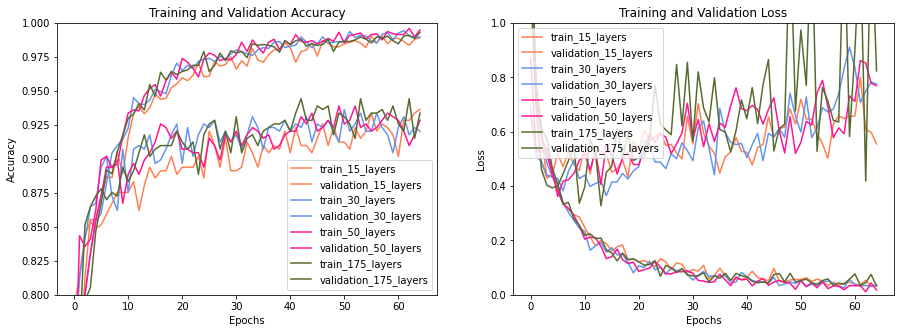

In [10]:
plot_accuracy_loss_comparison(histories_dict)

# 5) Tests divers

## SVM

In [ ]:
from keras import regularizers
def SVM_Architecture(model, nClasses):
  
  #Partie convolutive : on garde les paramètres des couches convolutives
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification SVM
  #x = Dense(256)(x)
  #x = Activation('relu')(x)
  x = Dense(nClasses, kernel_regularizer=regularizers.l2(0.01))(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_svm = SVM_Architecture(model, nClasses)
model_resnet50_svm.compile(loss='squared_hinge', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_resnet50_svm.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_svm.save('./Modeles/ResNet50_SVM.h5')

Epoch 1/65
56/56 [==============================] - 493s 9s/step - loss: 1.2774 - accuracy: 0.4507 - val_loss: 1.1942 - val_accuracy: 0.5942
Epoch 2/65
56/56 [==============================] - 42s 741ms/step - loss: 1.1723 - accuracy: 0.6410 - val_loss: 1.1370 - val_accuracy: 0.6923
Epoch 3/65
56/56 [==============================] - 40s 720ms/step - loss: 1.1314 - accuracy: 0.7022 - val_loss: 1.1040 - val_accuracy: 0.7401
Epoch 4/65
56/56 [==============================] - 40s 715ms/step - loss: 1.1030 - accuracy: 0.7435 - val_loss: 1.0906 - val_accuracy: 0.7613
Epoch 5/65
56/56 [==============================] - 39s 697ms/step - loss: 1.0827 - accuracy: 0.7729 - val_loss: 1.0721 - val_accuracy: 0.7905
Epoch 6/65
56/56 [==============================] - 40s 718ms/step - loss: 1.0774 - accuracy: 0.7803 - val_loss: 1.0668 - val_accuracy: 0.8064
Epoch 7/65
56/56 [==============================] - 40s 706ms/step - loss: 1.0651 - accuracy: 0.7973 - val_loss: 1.0595 - val_accuracy: 0.8223
E

In [ ]:
study_model(model_resnet50_svm, labels, test_generator, executionTime)

Durée d'entraînement : 3037.75 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.859375   0.862291  0.859375  0.860175


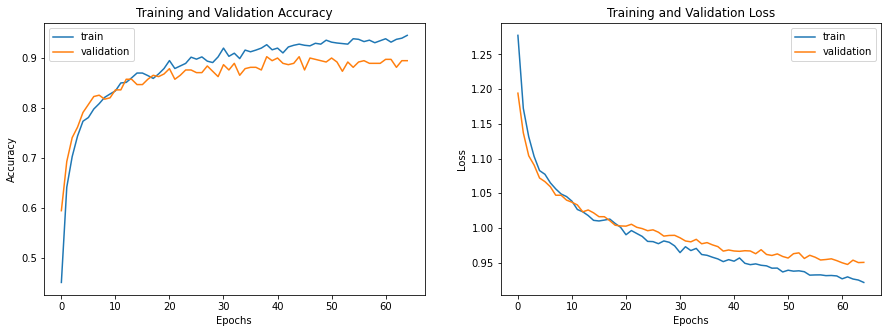

In [ ]:
plot_accuracy_loss(history)

In [ ]:
model_resnet50_svm_2 = load_model("./Modeles/ResNet50_SVM.h5")
model_resnet50_svm_2.compile(loss='squared_hinge', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
cb_list=[es]
epochs_nb = 35

In [ ]:
startTime=time.time()
history = model_resnet50_svm_2.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator, callbacks=cb_list)
executionTime2 = (time.time() - startTime)
model_resnet50_svm_2.save('./Modeles/ResNet50_SVM_2.h5')

Epoch 1/35
56/56 [==============================] - 50s 833ms/step - loss: 0.9234 - accuracy: 0.9377 - val_loss: 0.9438 - val_accuracy: 0.8939
Epoch 2/35
56/56 [==============================] - 41s 723ms/step - loss: 0.9228 - accuracy: 0.9354 - val_loss: 0.9477 - val_accuracy: 0.8992
Epoch 3/35
56/56 [==============================] - 40s 714ms/step - loss: 0.9217 - accuracy: 0.9383 - val_loss: 0.9449 - val_accuracy: 0.8939
Epoch 4/35
56/56 [==============================] - 40s 716ms/step - loss: 0.9199 - accuracy: 0.9411 - val_loss: 0.9415 - val_accuracy: 0.8966
Epoch 5/35
56/56 [==============================] - 40s 706ms/step - loss: 0.9213 - accuracy: 0.9360 - val_loss: 0.9432 - val_accuracy: 0.9019
Epoch 6/35
56/56 [==============================] - 41s 733ms/step - loss: 0.9187 - accuracy: 0.9411 - val_loss: 0.9453 - val_accuracy: 0.8992
Epoch 7/35
56/56 [==============================] - 42s 748ms/step - loss: 0.9174 - accuracy: 0.9456 - val_loss: 0.9451 - val_accuracy: 0.8859

In [ ]:
study_model(model_resnet50_svm_2, labels, test_generator, executionTime2)

Durée d'entraînement : 1501.65 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.880208   0.879666  0.880208  0.879819


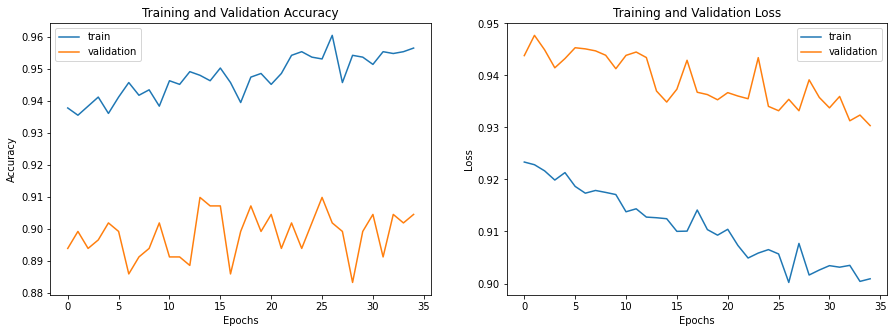

In [ ]:
plot_accuracy_loss(history)

## ResNet50 avec 1 seule couche de Dense

In [ ]:
def Architecture_small(model, nClasses):
  
  #Partie convolutive : on garde les paramètres des couches convolutives
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

In [ ]:
input_shape, train_generator, test_generator, validation_generator =  makeGeneratorsResNet(inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50_small = Architecture_small(model, nClasses)
model_resnet50_small.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50_small.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50_small.save('./Modeles/ResNet50_small.h5')

Epoch 1/65
56/56 [==============================] - 47s 762ms/step - loss: 1.7827 - accuracy: 0.4745 - val_loss: 1.1204 - val_accuracy: 0.6446
Epoch 2/65
56/56 [==============================] - 40s 720ms/step - loss: 1.0416 - accuracy: 0.6614 - val_loss: 0.8556 - val_accuracy: 0.7294
Epoch 3/65
56/56 [==============================] - 40s 719ms/step - loss: 0.8683 - accuracy: 0.7242 - val_loss: 0.7075 - val_accuracy: 0.7825
Epoch 4/65
56/56 [==============================] - 40s 717ms/step - loss: 0.8076 - accuracy: 0.7446 - val_loss: 0.7075 - val_accuracy: 0.7878
Epoch 5/65
56/56 [==============================] - 40s 713ms/step - loss: 0.7385 - accuracy: 0.7724 - val_loss: 0.6488 - val_accuracy: 0.7958
Epoch 6/65
56/56 [==============================] - 40s 719ms/step - loss: 0.6577 - accuracy: 0.7820 - val_loss: 0.6257 - val_accuracy: 0.8196
Epoch 7/65
56/56 [==============================] - 40s 717ms/step - loss: 0.6156 - accuracy: 0.8069 - val_loss: 0.5963 - val_accuracy: 0.8037

In [ ]:
study_model(model_resnet50_small, labels, test_generator, executionTime2)

Durée d'entraînement : 1501.65 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.861979    0.86327  0.861979  0.862374


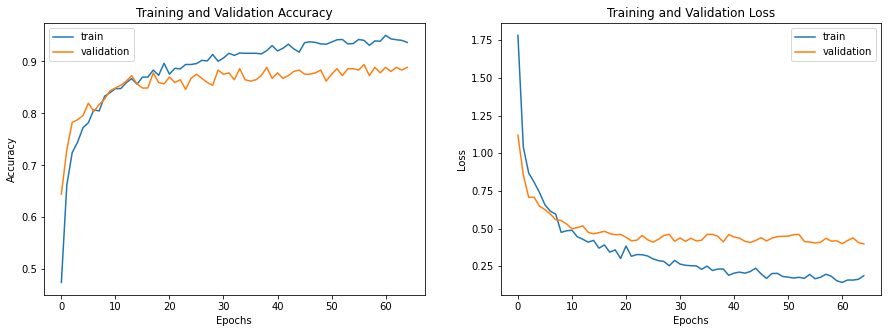

In [ ]:
plot_accuracy_loss(history)

# 6) Etude du meilleur modèle

In [24]:
ordered_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [25]:
def classificationReport(modelName, inputFolder):

    model = load_model(f'./Modeles/{modelName}.h5')
    test_generator = testGenerator(inputFolder)
    preds         = model.predict(test_generator)
    preds_classes = [i.argmax() for i in preds]
    y_true        = test_generator.classes

    classificationReport = classification_report(y_true, preds_classes, target_names=ordered_labels)
    print(classificationReport)

In [26]:
modelName = "ResNet50_ft175"
classificationReport(modelName, inputFolder)

Found 384 images belonging to 6 classes.
              precision    recall  f1-score   support

   cardboard       0.98      0.93      0.96        61
       glass       0.99      0.91      0.95        76
       metal       0.86      0.95      0.90        62
       paper       0.93      0.93      0.93        90
     plastic       0.87      0.93      0.90        73
       trash       0.89      0.77      0.83        22

    accuracy                           0.92       384
   macro avg       0.92      0.91      0.91       384
weighted avg       0.93      0.92      0.92       384



Found 384 images belonging to 6 classes.
Durée d'entraînement : 3810.54 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.921875   0.925006  0.921875  0.922167


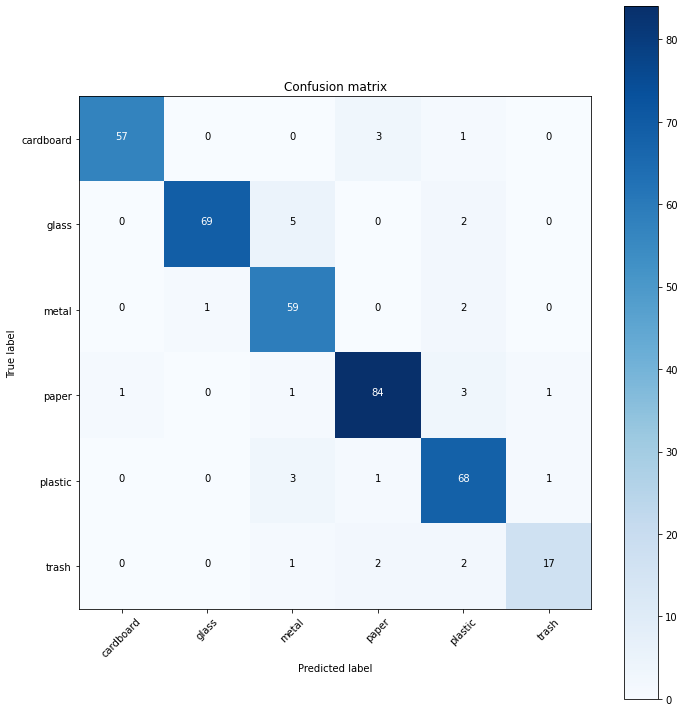

In [27]:
modelName = "ResNet50_ft175"
model = load_model(f'./Modeles/{modelName}.h5')
test_generator = testGenerator(inputFolder)
study_model(model, ordered_labels, test_generator, 3810.54, True)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              